In [1]:
import warnings
warnings.filterwarnings('ignore')

# Matplotlib inline magic command
%matplotlib inline

In [2]:
# Initial imports
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
from collections import Counter
import psycopg2
from config import db_password
import json
from pandas.io.json import json_normalize
import mysql.connector
from sqlalchemy import create_engine
from os import walk
import time
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [3]:
# Scikit-Learn dependencies
from sklearn.preprocessing import StandardScaler, LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix
from sklearn.decomposition import PCA

In [4]:
# Connect to AWS
def getDBengine1():
    user = 'postgres'
    passw = db_password
    host = 'policekillings.cv95lgysyvwq.us-east-1.rds.amazonaws.com'
    port = 5432
    database = 'PoliceKillings'
    engine_1 = create_engine(f'postgres+psycopg2://' + user + ':' + passw + '@' + host + ':' + str(port) + '/' + database ,  echo=False)
    return engine_1

In [5]:
# Load database into DataFrame
def getData1():
    s_statement = "select * from public.police_killings"
    # df = pd.read_sql(s_statement, con=getDBengine())
    try:
        df = pd.read_sql(s_statement, con=getDBengine1())
    except:
        print('failed')
    return df

In [6]:
killings_df = getData1()
killings_df.shape
print(killings_df.columns)

Index(['Victim_Age', 'Victim_Gender', 'Victim_Race', 'Date', 'City', 'State',
       'County', 'Responsible_Agency', 'Cause_of_death', 'Brief_Description ',
       'Criminal_Charges', 'Mental_Illness', 'Armed_Status', 'Threat_Level ',
       'Fleeing ', 'Body_Camera', 'Geography', 'Encounter_Type ',
       'Initial_Reason_for_Encounter ', 'Call_for_Service'],
      dtype='object')


In [7]:
# Load the data
file_path = 'Resources/2013-2020_Police_Killings_Revised.xlsx' 
killings_df = pd.read_excel(file_path)                         
killings_df

,Victim's age,Victim's gender,Victim's race,Date of Incident (month/day/year),County,Agency responsible for death,Cause of death,Symptoms of mental illness?,Armed/Unarmed Status,Alleged Threat Level (Source: WaPo),Fleeing (Source: WaPo),Body Camera (Source: WaPo),Geography,Encounter Type (DRAFT),Initial Reported Reason for Encounter (DRAFT),Call for Service? (DRAFT)
0,Unknown,Male,Unknown Race,2021-04-18,NaN,Detroit Police Department,Gunshot,NaN,Allegedly Armed,attack,NaN,NaN,NaN,Part 1 Violent Crime,shooting,NaN
1,Unknown,Male,Unknown Race,2021-04-18,NaN,Douglasville Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown,Male,Unknown Race,2021-04-18,NaN,Fort Worth Police Department,Gunshot,NaN,Allegedly Armed,NaN,NaN,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
3,Unknown,Male,White,2021-04-18,NaN,Burnsville Police Department,Gunshot,NaN,Allegedly Armed,attack,car,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
4,Unknown,Male,Black,2021-04-17,NaN,Winter Haven Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,Domestic disturbance,Domestic disturbance (armed),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9077,21,Male,White,2013-01-01,Douglas,Douglas County Sheriff's Office,Gunshot,Drug or alcohol use,Allegedly Armed,NaN,NaN,NaN,Rural,NaN,NaN,NaN
9078,26,Male,White,2013-01-01,Blue Earth,Mankato Department of Public Safety,Taser,No,Unarmed/Did Not Have Actual Weapon,NaN,NaN,NaN,Suburban,NaN,NaN,NaN
9079,21,Male,Hispanic,2013-01-01,Pueblo,Pueblo Police Department,Gunshot,No,Allegedly Armed,NaN,NaN,NaN,Suburban,NaN,NaN,NaN
9080,49,Male,Hispanic,2013-01-01,San Juan,Farmington Police Department,Gunshot,No,Allegedly Armed,NaN,NaN,NaN,Urban,NaN,NaN,NaN


In [8]:
# Rename columns
killings_df.rename(columns = {"Victim's age" : 'Victim_Age', "Victim's gender" : 'Victim_Gender', 
                              "Victim's race" : 'Victim_Race', 'Date of Incident (month/day/year)' : 'Date',
                              'Agency responsible for death' : 'Responsible_Agency', 'Cause of death' : 'Cause_of_Death',
                              'A brief description of the circumstances surrounding the death' : 'Brief_Description',
                              'Criminal Charges?' : 'Criminal_Charges', 'Symptoms of mental illness?' : 'Mental_Illness', 
                              'Armed/Unarmed Status' : 'Armed_Status', 'Alleged Threat Level (Source: WaPo)' : 'Threat_Level', 
                              'Fleeing (Source: WaPo)' : 'Fleeing', 'Body Camera (Source: WaPo)' : 'Body_Camera', 
                              'Encounter Type (DRAFT)' : 'Encounter_Type', 
                              'Initial Reported Reason for Encounter (DRAFT)' : 'Initial_Reason_for_Encounter',
                              'Call for Service? (DRAFT)' : 'Call_for_Service'}, inplace = True)

killings_df.head()

,Victim_Age,Victim_Gender,Victim_Race,Date,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service
0,Unknown,Male,Unknown Race,2021-04-18,NaN,Detroit Police Department,Gunshot,NaN,Allegedly Armed,attack,NaN,NaN,NaN,Part 1 Violent Crime,shooting,NaN
1,Unknown,Male,Unknown Race,2021-04-18,NaN,Douglasville Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Unknown,Male,Unknown Race,2021-04-18,NaN,Fort Worth Police Department,Gunshot,NaN,Allegedly Armed,NaN,NaN,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
3,Unknown,Male,White,2021-04-18,NaN,Burnsville Police Department,Gunshot,NaN,Allegedly Armed,attack,car,NaN,NaN,Other Non-Violent Offense,carjacking,NaN
4,Unknown,Male,Black,2021-04-17,NaN,Winter Haven Police Department,Gunshot,NaN,NaN,NaN,NaN,NaN,NaN,Domestic disturbance,Domestic disturbance (armed),NaN


In [9]:
# Delete columns
del killings_df['Victim_Gender']
#del killings_df['City']
#del killings_df['State']
#del killings_df['Criminal_Charges']
#del killings_df['Brief_Description']

In [10]:
# Find null values
for column in killings_df.columns:
    print(f'Column {column} has {killings_df[column].isnull().sum()} null values')

Column Victim_Age has 8 null values
Column Victim_Race has 0 null values
Column Date has 0 null values
Column County has 26 null values
Column Responsible_Agency has 4 null values
Column Cause_of_Death has 0 null values
Column Mental_Illness has 69 null values
Column Armed_Status has 6 null values
Column Threat_Level has 2394 null values
Column Fleeing has 3077 null values
Column Body_Camera has 3147 null values
Column Geography has 31 null values
Column Encounter_Type has 4310 null values
Column Initial_Reason_for_Encounter has 4310 null values
Column Call_for_Service has 5539 null values


In [11]:
# Replace empty/blank values for Age, Threat_Level, Fleeing, Body_Camera, Encounter_Type, Initial_Reason_for_Encounter, 
# Call_for_Service and re-verify null values

# Column: Age
killings_df['Victim_Age'].replace({'Unknown': '0'}, inplace = True) 
                                                                    
# Column: Threat_Level
killings_df['Threat_Level'].replace({None: 'undetermined'}, inplace = True)

# Column: Fleeing
killings_df['Fleeing'].replace({None: 'unknown'}, inplace = True)

# Column: Body_Camera
killings_df['Body_Camera'].replace({None: 'unknown'}, inplace = True)

# Column: Encounter_Type
killings_df['Encounter_Type'].replace({None: 'Unknown'}, inplace = True)

# Column: Initial_Reason_for_Encounter
killings_df['Initial_Reason_for_Encounter'].replace({None: 'unknown'}, inplace = True)

# Column: Call_for_Service
killings_df['Call_for_Service'].replace({None: 'Unavailable'}, inplace = True)

# Verify null values
for column in killings_df.columns:
    print(f'Column {column} has {killings_df[column].isnull().sum()} null values')

Column Victim_Age has 8 null values
Column Victim_Race has 0 null values
Column Date has 0 null values
Column County has 26 null values
Column Responsible_Agency has 4 null values
Column Cause_of_Death has 0 null values
Column Mental_Illness has 69 null values
Column Armed_Status has 6 null values
Column Threat_Level has 0 null values
Column Fleeing has 0 null values
Column Body_Camera has 0 null values
Column Geography has 31 null values
Column Encounter_Type has 0 null values
Column Initial_Reason_for_Encounter has 0 null values
Column Call_for_Service has 0 null values


In [12]:
# Drop null values
killings_df = killings_df.dropna(how = 'any')
killings_df = killings_df.reset_index().drop(['index'], axis = 1)

In [13]:
# Inspect column data types
killings_df.dtypes

Victim_Age                              object
Victim_Race                             object
Date                            datetime64[ns]
County                                  object
Responsible_Agency                      object
Cause_of_Death                          object
Mental_Illness                          object
Armed_Status                            object
Threat_Level                            object
Fleeing                                 object
Body_Camera                             object
Geography                               object
Encounter_Type                          object
Initial_Reason_for_Encounter            object
Call_for_Service                        object
dtype: object

In [14]:
# Change Victim_Age data type from object to int
killings_df['Victim_Age'] = killings_df['Victim_Age'].astype(str).astype(int)
killings_df.dtypes

Victim_Age                               int32
Victim_Race                             object
Date                            datetime64[ns]
County                                  object
Responsible_Agency                      object
Cause_of_Death                          object
Mental_Illness                          object
Armed_Status                            object
Threat_Level                            object
Fleeing                                 object
Body_Camera                             object
Geography                               object
Encounter_Type                          object
Initial_Reason_for_Encounter            object
Call_for_Service                        object
dtype: object

In [15]:
# Extract year from Date and create new column Year
killings_df['Year'] = pd.DatetimeIndex(killings_df['Date']).year

# Extract month from Date and create new column Month
killings_df['Month'] = pd.DatetimeIndex(killings_df['Date']).month

# Extract day from Date and create new column Day
killings_df['Day'] = pd.DatetimeIndex(killings_df['Date']).day

In [16]:
# Get holiday from Date and create new column Holiday
dr = pd.date_range(start='2013-01-01', end='2021-04-18')
df = pd.DataFrame()
df['Date'] = dr

cal = calendar()
holidays = cal.holidays(start=dr.min(), end=dr.max())

killings_df['Holiday'] = killings_df['Date'].dt.date.astype('datetime64').isin(holidays)

In [17]:
# Use get_dummies() to transform text values into numerical values
killings_encoded = pd.get_dummies(killings_df, columns = 
                                  ['Cause_of_Death', 'Mental_Illness', 'Armed_Status', 'Threat_Level', 'Fleeing', 
                                   'Body_Camera', 'Geography', 'County', 'Responsible_Agency', 'Encounter_Type', 
                                   'Initial_Reason_for_Encounter', 'Call_for_Service'])

killings_encoded.head()

,Victim_Age,Victim_Race,Date,Year,Month,Day,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",Cause_of_Death_Bean bag,...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,Hispanic,2021-04-14,2021,4,14,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,Unknown Race,2021-04-10,2021,4,10,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,Unknown Race,2021-04-10,2021,4,10,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,Unknown Race,2021-04-10,2021,4,10,False,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,Unknown Race,2021-04-09,2021,4,9,False,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [18]:
# Drop Date column
killings_encoded = killings_encoded.drop(['Date'], axis = 1)

In [19]:
killings_encoded['Victim_Race'].value_counts()

White               3935
Black               2259
Hispanic            1565
Unknown Race         903
Asian                134
Native American      127
Pacific Islander      50
Hispanic               1
Name: Victim_Race, dtype: int64

In [20]:
killings_df[killings_df['Victim_Race'] == 'Hispanic ']

,Victim_Age,Victim_Race,Date,County,Responsible_Agency,Cause_of_Death,Mental_Illness,Armed_Status,Threat_Level,Fleeing,Body_Camera,Geography,Encounter_Type,Initial_Reason_for_Encounter,Call_for_Service,Year,Month,Day,Holiday
217,26,Hispanic,2021-01-27,Bexar,San Antonio Police Department,Gunshot,No,Allegedly Armed,other,foot,yes,Suburban,Traffic Stop,Traffic violation,No,2021,1,27,False


In [21]:
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Hispanic ', 'Hispanic')

In [22]:
killings_encoded[killings_encoded['Victim_Race'] != 'Hispanic ']

,Victim_Age,Victim_Race,Year,Month,Day,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",Cause_of_Death_Bean bag,Cause_of_Death_Beaten,...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,Hispanic,2021,4,14,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,Unknown Race,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,Unknown Race,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,Unknown Race,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,Unknown Race,2021,4,9,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,21,White,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8970,26,White,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8971,21,Hispanic,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8972,49,Hispanic,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [23]:
# Convert Victim_Race values to numbers
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('White', 1)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Black', 2)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Hispanic', 3)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Unknown Race', 4)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Asian', 5)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Native American', 6)
killings_encoded['Victim_Race'] = killings_encoded['Victim_Race'].replace('Pacific Islander', 7)

killings_encoded['Victim_Race']

0       3
1       4
2       4
3       4
4       4
       ..
8969    1
8970    1
8971    3
8972    3
8973    2
Name: Victim_Race, Length: 8974, dtype: int64

In [24]:
killings_encoded

,Victim_Age,Victim_Race,Year,Month,Day,Holiday,Cause_of_Death_Asphyxiated,"Cause_of_Death_Baton, Pepper Spray, Physical Restraint",Cause_of_Death_Bean bag,Cause_of_Death_Beaten,...,"Initial_Reason_for_Encounter_wellness check/erratic behavior, other: danger to self (suicide)","Initial_Reason_for_Encounter_wellness check/erratic behavior, shooting/shots fired","Initial_Reason_for_Encounter_wellness check/erratic behavior, warrant (failure to appear)","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense","Initial_Reason_for_Encounter_wellness check/erratic behavior, weapons offense (gun)",Call_for_Service_No,Call_for_Service_No,Call_for_Service_Unavailable,Call_for_Service_Yes,Call_for_Service_yes
0,46,3,2021,4,14,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,48,4,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,4,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,4,2021,4,10,False,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,50,4,2021,4,9,False,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,21,1,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8970,26,1,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8971,21,3,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
8972,49,3,2013,1,1,True,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Split Data into Training and Testing Sets

In [25]:
# Create features
X = pd.get_dummies(killings_encoded.drop(columns = ['Victim_Race']))

# Create target
y = pd.DataFrame(killings_encoded['Victim_Race'])

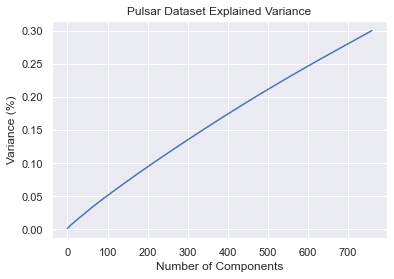

In [26]:
X_std = StandardScaler().fit_transform(killings_encoded)
pca = PCA(n_components=.3)
principalComponents = pca.fit_transform(X_std) # Plot the explained variances
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Police Killings Dataset Explained Variance')
plt.show()

In [27]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X_std)
pca_df = pd.DataFrame(principalComponents)

In [28]:
pca_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-2.052480,0.303854,6.231047,-0.669373,0.572409,1.470707,-0.307951,0.663620,1.410348,0.568750,-0.027035,0.010287,-0.295377,0.701621,-0.342636,0.168163,0.961329,-0.334045,-0.077810,0.183405
1,-3.556344,2.449907,2.337746,-1.118232,-4.673807,1.358409,1.414089,2.114854,0.393773,0.216214,-0.433427,0.330280,-0.124945,0.975118,0.049287,0.311088,-0.275505,0.498618,-0.514605,0.626862
2,-1.121289,4.369379,3.525716,-0.878304,0.338701,2.059969,-1.861657,-1.533383,3.317609,-0.351868,0.589448,0.064739,-2.167121,1.212991,-0.144199,-0.230182,1.225324,-0.468881,-0.223246,-0.517560
3,-2.514664,2.576372,1.992680,-0.827607,-2.092216,1.012340,-0.145622,0.998193,0.828970,-1.019340,0.199302,-0.028382,-0.505455,0.998411,-0.112893,0.351532,0.727788,-0.334782,-0.044807,0.565548
4,-3.791418,4.012003,1.836137,-1.286691,-2.999558,1.917746,-0.137808,0.695651,2.732093,0.112362,-0.779654,2.207752,-0.103236,0.055464,0.352448,-0.354252,0.126909,0.862137,0.263213,0.477801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8969,3.763304,0.049978,0.172852,-0.293052,-0.389240,1.084187,-0.473219,0.074179,0.400030,0.070528,0.339859,0.101413,-0.396758,0.129236,-0.473828,-0.126773,-0.239007,-0.171472,-0.055476,0.011922
8970,5.022858,2.085822,3.549671,-0.873620,3.154534,-1.402408,1.019137,-0.989402,0.596811,0.478717,-0.114665,-0.683724,1.036790,1.105759,0.876460,1.036265,-0.042674,0.775274,-0.888338,1.167833
8971,2.983105,0.954452,-0.405438,-0.363332,-0.152322,-1.933117,-0.637352,-0.414545,1.218716,-1.371837,-0.183869,-0.647265,-0.129109,-0.580819,-0.269256,-0.463047,0.753101,-1.280138,-0.401158,-0.888074
8972,3.513229,1.555053,-0.716782,-0.035567,-1.276858,-0.460360,-0.275879,0.456111,-1.044533,0.646507,0.730036,-0.085098,-0.264526,-0.693435,0.952387,-0.348907,0.136720,0.168780,0.441168,-0.477694


In [29]:
# Train, test, and split model
X_train, X_test, y_train, y_test = train_test_split(X,y)
                                                                                                   
y_train.shape

(6730, 1)

In [30]:
# Create a random forest classifier
rf_model = RandomForestClassifier()

In [31]:
# Fit the model
rf_model = rf_model.fit(X_train, y_train.values.ravel())

In [32]:
def multiclass_roc_auc_score(truth, pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(truth)
    truth = lb.transform(truth)
    pred = lb.transform(pred)
    return roc_auc_score(truth, pred, average=average)

In [33]:
# Calculate Balanced Accuracy Score
rf_y_pred = rf_model.predict(X_test)

In [34]:
# Calculate ROC accuracy score
multiclass_roc_auc_score(y_test, rf_y_pred)

0.5817021512900208

In [35]:
# Print classification report
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           1       0.54      0.87      0.67       988
           2       0.54      0.44      0.48       551
           3       0.53      0.22      0.31       395
           4       0.45      0.09      0.15       235
           5       0.33      0.03      0.05        38
           6       0.00      0.00      0.00        29
           7       0.67      0.25      0.36         8

    accuracy                           0.54      2244
   macro avg       0.44      0.27      0.29      2244
weighted avg       0.52      0.54      0.49      2244



In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 20, 50],
    'max_leaf_nodes': [2, 10, 20],
    'n_estimators': [100, 200, 1000],
    #'oob_score': [True],
    #'random_state': [0],
    'max_samples': [10, 20, 100],
    'max_features': [10, 20, 100],
    'min_samples_split': [2, 10, 20]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, 
                      cv = 3, n_jobs = -1, verbose = 2, return_train_score=True)
# Fit the grid search to the data
grid_search.fit(X_train, y_train);
grid_search.best_params_
best_grid = grid_search.best_estimator_
pprint(best_grid.get_params())
selector = RFE(rf_model, step=1, verbose=3)
selector = selector.fit(X_train, y_train)
print("Features sorted by their rank:")
pprint(sorted(zip(map(lambda x: round(x, 4), selector.ranking_), X)))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 20,
 'max_features': 100,
 'max_leaf_nodes': 20,
 'max_samples': 20,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}
Fitting estimator with 5989 features.
Fitting estimator with 5988 features.
Fitting estimator with 5987 features.
Fitting estimator with 5986 features.
Fitting estimator with 5985 features.
Fitting estimator with 5984 features.
Fitting estimator with 5983 features.
Fitting estimator with 5982 features.
Fitting estimator with 5981 features.
Fitting estimator with 5980 features.
Fitting estimator with 5979 features.
Fitting estimator with 5978 features.
Fitting estimator with 5977 features.
Fitting esti

Fitting estimator with 5786 features.
Fitting estimator with 5785 features.
Fitting estimator with 5784 features.
Fitting estimator with 5783 features.
Fitting estimator with 5782 features.
Fitting estimator with 5781 features.
Fitting estimator with 5780 features.
Fitting estimator with 5779 features.
Fitting estimator with 5778 features.
Fitting estimator with 5777 features.
Fitting estimator with 5776 features.
Fitting estimator with 5775 features.
Fitting estimator with 5774 features.
Fitting estimator with 5773 features.
Fitting estimator with 5772 features.
Fitting estimator with 5771 features.
Fitting estimator with 5770 features.
Fitting estimator with 5769 features.
Fitting estimator with 5768 features.
Fitting estimator with 5767 features.
Fitting estimator with 5766 features.
Fitting estimator with 5765 features.
Fitting estimator with 5764 features.
Fitting estimator with 5763 features.
Fitting estimator with 5762 features.
Fitting estimator with 5761 features.
Fitting esti

Fitting estimator with 5570 features.
Fitting estimator with 5569 features.
Fitting estimator with 5568 features.
Fitting estimator with 5567 features.
Fitting estimator with 5566 features.
Fitting estimator with 5565 features.
Fitting estimator with 5564 features.
Fitting estimator with 5563 features.
Fitting estimator with 5562 features.
Fitting estimator with 5561 features.
Fitting estimator with 5560 features.
Fitting estimator with 5559 features.
Fitting estimator with 5558 features.
Fitting estimator with 5557 features.
Fitting estimator with 5556 features.
Fitting estimator with 5555 features.
Fitting estimator with 5554 features.
Fitting estimator with 5553 features.
Fitting estimator with 5552 features.
Fitting estimator with 5551 features.
Fitting estimator with 5550 features.
Fitting estimator with 5549 features.
Fitting estimator with 5548 features.
Fitting estimator with 5547 features.
Fitting estimator with 5546 features.
Fitting estimator with 5545 features.
Fitting esti

Fitting estimator with 5354 features.
Fitting estimator with 5353 features.
Fitting estimator with 5352 features.
Fitting estimator with 5351 features.
Fitting estimator with 5350 features.
Fitting estimator with 5349 features.
Fitting estimator with 5348 features.
Fitting estimator with 5347 features.
Fitting estimator with 5346 features.
Fitting estimator with 5345 features.
Fitting estimator with 5344 features.
Fitting estimator with 5343 features.
Fitting estimator with 5342 features.
Fitting estimator with 5341 features.
Fitting estimator with 5340 features.
Fitting estimator with 5339 features.
Fitting estimator with 5338 features.
Fitting estimator with 5337 features.
Fitting estimator with 5336 features.
Fitting estimator with 5335 features.
Fitting estimator with 5334 features.
Fitting estimator with 5333 features.
Fitting estimator with 5332 features.
Fitting estimator with 5331 features.
Fitting estimator with 5330 features.
Fitting estimator with 5329 features.
Fitting esti